In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-28 13:15:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-28 13:15:05 (96.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
import tensorflow as tf
import helper_functions as hf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from sklearn.ensemble import VotingClassifier

### TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

In [3]:
def calculate_result(y_true,y_pred):
  acc = accuracy_score(y_true=y_true,y_pred=y_pred)

  #precision,recall,f1_score,support
  precision,recall,f1_score,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")

  metrics = {
      "acc":acc * 100,
      "precision": precision,
      "recall": recall,
      "f1_score": f1_score

  }

  return metrics


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-543a26fa-db37-48ce-dbf5-7a9b86291be8)


## 2022.07.04 - NLP 1

### Introduction
- Applied Problem
  - Multi-label classification: 文本分類
  - Sentiment Analysis
  - Sequence Generation
  - Audio->Speech --Translation--> Speech-> Audio
  - Natural Language Understanding like Chatbot or voice assistent
- All above problems is belong to the Seqeunce problem
  - how to determine the one or many
    - depends on your data. **the amount of value **that you will take into the input/output layer will influence the which type of sequence problem you are handling.
  - one to one
  - one to many
    - image cpation, give a image, output a sentence that contains multiple words to describe the image
  - many to one
    - Forecast. give pas few datas to predict  value in the next timestamp
    - sentiment analysis. give a sequence and output a class like positibe/negative
  - Many to many Synchronized
  - Many to Many UnSynchronized:
    - like translation

### Sentiment Analysis on Twitter dataset

### Data Collection - Download
- https://www.kaggle.com/c/nlp-getting-started

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-07-08 13:31:57--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.217.0.48, 172.217.2.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2022-07-08 13:31:57 (53.8 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
hf.unzip_data("nlp_getting_started.zip")

### Prepare The Data & Visualize

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
train_data_df = pd.read_csv("train.csv")
test_data_df = pd.read_csv("test.csv")
submission_data_df = pd.read_csv("sample_submission.csv")

FileNotFoundError: ignored

In [ ]:
submission_data_df.shape

(3263, 2)

In [ ]:
sum(train_data_df["location"].isna())

2533

In [ ]:
(train_data_df["text"].isna()).mean()

0.0

In [ ]:
# to see if the dataset is balanced
train_data_df["target"].value_counts() / len(train_data_df)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [ ]:
### Visualize the text example
import random
delta = 5
random_index = np.random.randint(0,len(train_data_df)-delta)
for row in train_data_df[["text","target"]][random_index:random_index+delta].itertuples():
  _,text,target = row
  label = "Yes" if target > 0 else "No"
  print(f"Disaster: {label}")
  print(f"Text: {text}\n")
  print("-"*100)

Disaster: Yes
Text: #Sismo DETECTADO #JapÌ_n 06:32:43 Miyagi Estimated seismic intensity 0 JST #??

----------------------------------------------------------------------------------------------------
Disaster: No
Text: Sinkhole Selfies: You Wont Believe What's In The Brooklyn Sinkhole!: 
        Sinkhole Selfies: You Wont Belie... http://t.co/A3b5n3rcr5

----------------------------------------------------------------------------------------------------
Disaster: Yes
Text: MRW when a sinkhole opens up beneath my friends and I... #gif #funny #lol #comedy #iFunny #video #image #RT http://t.co/XiYdYfptru

----------------------------------------------------------------------------------------------------
Disaster: No
Text: Talk on GOZ is fantastic. Most interesting fact so far is that they manually bought all the .ru domains to sinkhole rather than seek co-op.

----------------------------------------------------------------------------------------------------
Disaster: No
Text: nothing 

In [ ]:
### Split the train dataset into training and validation
X = train_data_df["text"]
y = train_data_df["target"]

# pandas to numpy using to_numpy()
X_train,X_validation,y_train,y_validation = train_test_split(X.to_numpy(),y.to_numpy(),test_size=0.1,random_state=42)

In [ ]:
X_train[:10], y_train[:10]

(array(["'McFadden Reportedly to Test Hamstring Thursday' via @TeamStream http://t.co/jWq4KvJH2j",
        'w--=-=-=-[ NEMA warns Nigerians to prepare for drought http://t.co/5uoOPhSqU3',
        "When I was cooking earlier I got electrocuted some crucial ?????? now I'm psychic lol",
        "I'm On Fire.  http://t.co/WATsmxYTVa",
        "More than 40 families affected by the fatal outbreak of Legionnaires' disease in Edinburgh are to sue two comp... http://t.co/vsoXioOy78",
        'Why do u ruin everything?  @9tarbox u ruined the sour cream and u put a brick of cheese in the freezer..dummy',
        'http://t.co/c1H7JECFrV @RoyalCarribean do your passengers know about the mass murder that takes place in the #FaroeIslands every year?',
        "WACKOES like #MicheleBachman predict the WORLD will SOON be OBLITERATED by a burning firey INFERNO but can't accept #GlobalWarming!! HELLO!!",
        '@Reuters people like you should be charged after the inevitable rioting for contributing to

### Tokenization
- Tokenization(TextVectorization): convert text to numeric value
  - https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
  - straght mapping the text to number. but it is unrealisitc because the words should have mutual relationships 
  - Flow:
    - word segmentation: convert a sequence to a list that include str type of words
      - word is token
    - convert words to the numeric value in a list like vector
  - cannot be learned because the mapping operation is deterministic 
- Embedding Layer
  - project all thw words to a share vector spaces
  - rich representation of relationship between words
  - can be learned well => why because the embedding itself also be performed through neural network like another layer/model
    - it is neural network that can learn pattern from our data. that means we can also use pre-trained for embediing purpose
      - like word2vec

In [ ]:
# default tokenization
text_vectorizer = TextVectorization(
    max_tokens = None, # will have "max_tokens - 1" index_number to represent word, # why -1: <OOV>, its actual value will be [UNK] UNKNOWN
    # if max_tokens is set up. then only keep the most common words int the volcabulary and assign the index to the token
    # the remaining words will be marked as <OOV> out of volcabulary
    standardize = "lower_and_strip_punctuation", # the preprocessing on the word
    split = "whitespace", # define how to do the word segmentation
    output_mode = "int", # use integer number to represent the words -> index
    output_sequence_length = False, # define how many words that model will see, will padding or truncate
    ngrams = None, # mean each group just contain n word, by default n = 1
    pad_to_max_tokens = False # supplement the remaining token using reserved index for those sequence that didn't have much words
)

In [ ]:
# the average of number of words in a sequence in train dataset 
np.mean([len(i.split()) for i in X_train])

14.87447088016348

In [ ]:
MAX_TOKENS = 10000
MAX_LENGTH = 15

text_vectorizer = TextVectorization(
    max_tokens = MAX_TOKENS,
    output_mode = "int",
    output_sequence_length = MAX_LENGTH
)

In [ ]:
# use adapt method to apply the transformation , it act like as fit but use act in the sequence problem
# and why need to adapt, because you need let the vectorizer know how many words should be store in the volcabulary 
text_vectorizer.adapt(X_train)

In [ ]:
sample_sentence = "There oaisudo is a good news"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 75,   1,   9,   3, 135,  57,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
import random
random_sentence = random.choice(X_train)
print(f"random_sentence:{random_sentence}")
print()
print(f"text_vectorizer:{text_vectorizer([random_sentence])}")
print("Word Segmentation:\n")
for ind in text_vectorizer(random_sentence).numpy():
  print(text_vectorizer.get_vocabulary()[ind])

random_sentence:Why are you engulfed by low self-image? Take the quiz: http://t.co/CImUbwEyiB http://t.co/9R5FstS7Bd

text_vectorizer:[[  92   21   12  392   18  652 1253  163    2  888    1    1    0    0
     0]]
Word Segmentation:

why
are
you
engulfed
by
low
selfimage
take
the
quiz
[UNK]
[UNK]





### Volcabulary
- the order of elemtns in the volcabulary is represent the used freq across all the input data

In [ ]:
volcabulary = text_vectorizer.get_vocabulary()

In [ ]:
# the most common words
# empty string should be used in padding which is applied in the output_sequence_length in this case.
print(volcabulary[:5])

# the least common words
print(volcabulary[-5:])

['', '[UNK]', 'the', 'a', 'in']
['pakthey', 'pakistan\x89Ûªs', 'pakistans', 'pajamas', 'paints']


### Embedding Layer
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
- basically the functionality is separate betweeen tokenization and embedding layer
  - but the data type of input need to ne integer number so we can combine those two transformation together
  - to find richer representation

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim = MAX_TOKENS, # weights will be input_dim * output_dim
                          output_dim = 128, # 選可以被8整除的, GPU computing can benefit from this
                          input_length = MAX_LENGTH)

In [ ]:
import random
random_sentence = random.choice(X_train)
text_random_sentence = text_vectorizer([random_sentence])
embedded_sentence = embedding(text_vectorizer([random_sentence]))
print(random_sentence)
embedded_sentence,embedded_sentence.shape,embedded_sentence[0][0]

@Chibi877 --head. It hit the wall behind him with a loud bang. 'Language!' Drake shouted at him before getting up. 'I'm going out stay--


(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.02537415,  0.01796261,  0.03889121, ...,  0.0001517 ,
          -0.02249806, -0.02531942],
         [ 0.00938541,  0.04313347,  0.00741323, ...,  0.0317026 ,
           0.00488311,  0.02195742],
         [ 0.0207344 ,  0.02647728, -0.02883315, ..., -0.02516292,
          -0.02341386, -0.01269609],
         ...,
         [ 0.0443331 ,  0.04278595, -0.02658069, ..., -0.04398557,
           0.04211092, -0.02826111],
         [-0.03780637, -0.00366677,  0.03725323, ..., -0.02707984,
           0.03800091,  0.01935701],
         [ 0.04160402, -0.01079696, -0.01495091, ..., -0.00794647,
          -0.01499572,  0.038808  ]]], dtype=float32)>,
 TensorShape([1, 15, 128]),
 <tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.02537415,  0.01796261,  0.03889121,  0.04620948,  0.02376446,
         0.02216825, -0.00925846,  0.03761736,  0.04362067, -0.01454773,
         0.01099662, -0.01696429,  0.03232808,  0.02234937, -0.03

In [ ]:
# the weights of embedding layerr is like a lookup matrix, will based on the index of input to find the ouptut dim for each index
# and compose (number of index in the sentence, output_dim) matrix
embedding.weights[0].numpy()[text_random_sentence.numpy()[0]][0] == embedded_sentence[0][0]

<tf.Tensor: shape=(128,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  Tr

## 2022.07.05 - NLP Part 2

### Modeling
- Models Experiments:
  - Naive Bayse Model (baseline): https://scikit-learn.org/stable/modules/naive_bayes.html
  - DNN
  - LSTM
  - GRU
  - Bidirectional-LSTM
  - 1D CNN
  - Feature Extracrtion Model from tensorflow hub
  - same with above model but with 10% training dataset only
- RNN/LSTM/GRU is suitable for handling the Sequence problem

### Base Model_0 : Naive Bayse with tfidf
- TF-IDF preprocessing
- naive base

In [ ]:
from sklearn.preprocessing.text import TfidfVectorizer

In [ ]:
pipeline = Pipeline([
    ("tfidf",TfidfVectorizer()),
    ("MultinomialNb",MultinomialNB())                 
])

In [ ]:
X_train[:10]

array(["'McFadden Reportedly to Test Hamstring Thursday' via @TeamStream http://t.co/jWq4KvJH2j",
       'w--=-=-=-[ NEMA warns Nigerians to prepare for drought http://t.co/5uoOPhSqU3',
       "When I was cooking earlier I got electrocuted some crucial ?????? now I'm psychic lol",
       ...,
       'Omron HEM-712C Automatic Blood Pressure Monitor STANDARD AND LARGE BP CUFFS http://t.co/gJBAInQWN9 http://t.co/jPhgpL1c5x',
       'Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY',
       'I moved to England five years ago today. What a whirlwind of time it has been! http://t.co/eaSlGeA1B7'],
      dtype=object)

In [ ]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('MultinomialNb', MultinomialNB())])

In [ ]:
pipeline.score(X_validation,y_validation)

0.7782152230971129

In [ ]:
y_pred = pipeline.predict(X_validation)
model_0_result = calculate_result(y_validation,y_pred)

### Model_1: Dense Neural Network

In [ ]:
SAVE_DIR = "model_expeirment"

In [ ]:
model_1_seq = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[1],dtype=tf.string),
    text_vectorizer,
    embedding,
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [ ]:
# Modeling
inputs = tf.keras.layers.Input(shape=[1],dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# to make sure the output layerr only contains 1 neuron, so do the flatten using globally avreage pooling
# like average the feature from multiple tokens
x = tf.keras.layers.GlobalAveragePooling1D()(x)
#tf.keras.layers.MaxPooling1D()
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs,outputs)

In [ ]:
model_1_seq.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-train

In [ ]:
history_1 = model_1_seq.fit(X_train,y_train,
            epochs = 5,
            # need to specify the validation data and its lavel
            validation_data = (X_validation,y_validation),
            callbacks = [hf.create_tensorboard_callback(SAVE_DIR,"model_1_dense")]
)

Saving TensorBoard log files to: model_expeirment/model_1_dense/20220708-144448
Epoch 1/5
215/215 [==============================] - 4s 8ms/step - loss: 0.6097 - accuracy: 0.7024 - val_loss: 0.5416 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4387 - accuracy: 0.8210 - val_loss: 0.4848 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3450 - accuracy: 0.8619 - val_loss: 0.4773 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2821 - accuracy: 0.8946 - val_loss: 0.4855 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2355 - accuracy: 0.9121 - val_loss: 0.5032 - val_accuracy: 0.7808


In [ ]:
model_1.evaluate(X_validation,y_validation)

24/24 [==============================] - 0s 6ms/step - loss: 0.5032 - accuracy: 0.7808


[0.5031970143318176, 0.7808399200439453]

In [ ]:
model_1_pred = tf.squeeze(np.round(model_1.predict(X_validation)))
model_1_result = calculate_result(y_validation,model_1_pred)

In [ ]:
np.array(list(model_1_result.values())) > np.array(list(model_0_result.values()))

array([ True, False,  True,  True])

### Tensorflow Projector Tool
- visualize the learned patterns/weights in the embeddiing layer
- https://www.tensorflow.org/text/guide/word_embeddings

In [ ]:
words_in_volcb = text_vectorizer.get_vocabulary()
len(words_in_volcb),words_in_volcb[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
embedding_weights = model_1.get_layer("embedding").get_weights()[0]
embedding_weights.shape

(10000, 128)

In [ ]:
# tensorflow projector. a tool to visualize the embedding words

In [ ]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_volcb):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedding_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# use command to download file from colab or from the google drive
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2022.07.06 - NLP Part 3

### RNN Overview
- Recurrent Neural Network
  - learn the pattern from sequential hidden-layer and input-layer

### Model 2 - LSTM Model
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

In [ ]:
model_2_seq = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[1],dtype=tf.string),
    text_vectorizer,
    embedding,
    tf.keras.layers.LSTM(64,return_sequences=False),
    tf.keras.layers.Dense(1,activation="sigmoid")
])

In [ ]:
inputs = tf.keras.layers.Input(shape=[1],dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = tf.keras.layers.LSTM(64,return_sequences=False)(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs,outputs)

(None, 15, 128)


In [ ]:
model_2_seq.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2_seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.layers[-2].weights

[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(128, 256) dtype=float32, numpy=
 array([[ 0.12481034,  0.11416981,  0.01283804, ..., -0.00215477,
          0.03219643,  0.00305623],
        [ 0.02930525, -0.09790188, -0.09935069, ...,  0.02241072,
         -0.03341427,  0.10395712],
        [-0.06420219, -0.01227036, -0.04162228, ..., -0.09049523,
         -0.08063537, -0.06983787],
        ...,
        [ 0.01982048,  0.02066928, -0.00362846, ...,  0.01133564,
         -0.01283339, -0.03247896],
        [ 0.00654823, -0.1030446 , -0.05425277, ...,  0.10754341,
          0.08293936, -0.0616551 ],
        [-0.11850119,  0.10079181, -0.0167242 , ...,  0.0077056 ,
         -0.01008546,  0.03038147]], dtype=float32)>,
 <tf.Variable 'lstm/lstm_cell/recurrent_kernel:0' shape=(64, 256) dtype=float32, numpy=
 array([[-0.12809968,  0.08980711,  0.00854171, ..., -0.01478239,
          0.06597292, -0.01975574],
        [ 0.07176717,  0.04822659,  0.07684803, ...,  0.10738986,
         -0.02892595, 

In [ ]:
history_2 = model_2_seq.fit(X_train,y_train,
            epochs=5,
            validation_data = (X_validation,y_validation),
            callbacks=[hf.create_tensorboard_callback(SAVE_DIR,"model_2_lstm")])

Saving TensorBoard log files to: model_expeirment/model_2_lstm/20220708-144706
Epoch 1/5
215/215 [==============================] - 8s 8ms/step - loss: 0.2229 - accuracy: 0.9235 - val_loss: 0.5653 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1593 - accuracy: 0.9413 - val_loss: 0.6370 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1278 - accuracy: 0.9521 - val_loss: 0.6426 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1040 - accuracy: 0.9600 - val_loss: 0.8789 - val_accuracy: 0.7467
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0865 - accuracy: 0.9657 - val_loss: 0.8831 - val_accuracy: 0.7612


In [ ]:
model_2_pred = tf.squeeze(np.round(model_2.predict(X_validation)))
model_2_result = calculate_result(y_validation,model_2_pred)

In [ ]:
np.array(list(model_2_result.values())) > np.array(list(model_0_result.values()))

array([False, False, False, False])

### Model3 - Gate Recurrent Network
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU

In [ ]:
inputs = tf.keras.layers.Input(shape=[1],dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
#x = tf.keras.layers.LSTM(64,return_sequences=False)(x)
# the sequential model need to take timeseries data as input but output can be choosed to return a series of ooutputs or just the final output
x = tf.keras.layers.GRU(64,return_sequences = False)(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs)

(None, 15, 128)


In [ ]:
model_3.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(X_train,y_train,
            epochs=5,
            validation_data = (X_validation,y_validation),
            callbacks=[hf.create_tensorboard_callback(SAVE_DIR,"model_3_GRU")])

Saving TensorBoard log files to: model_expeirment/model_3_GRU/20220707-132627
Epoch 1/5
215/215 [==============================] - 3s 8ms/step - loss: 0.1519 - accuracy: 0.9418 - val_loss: 0.7377 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0847 - accuracy: 0.9707 - val_loss: 0.7827 - val_accuracy: 0.7533
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0692 - accuracy: 0.9745 - val_loss: 0.9674 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0639 - accuracy: 0.9758 - val_loss: 0.9276 - val_accuracy: 0.7428
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0528 - accuracy: 0.9780 - val_loss: 1.2251 - val_accuracy: 0.7362


In [ ]:
model_3.evaluate(X_validation,y_validation)

24/24 [==============================] - 0s 4ms/step - loss: 1.2251 - accuracy: 0.7362


[1.2250581979751587, 0.7362204790115356]

In [ ]:
model_3_pred = tf.squeeze(np.round(model_3.predict(X_validation)))
model_3_result = calculate_result(y_validation,model_3_pred)
np.array(list(model_3_result.values())) > np.array(list(model_0_result.values()))

array([False, False, False, False])

### Model 4 - Bidirectional RNN

In [ ]:
inputs = tf.keras.layers.Input(shape=[1],dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=False))(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs)

In [ ]:
model_4.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# forward and backward. so amount of output neuron * 2
model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-tra

In [ ]:
history_4 = model_4.fit(X_train,y_train,
            epochs=5,
            validation_data = (X_validation,y_validation),
            callbacks=[hf.create_tensorboard_callback(SAVE_DIR,"model_4_Bidirectional_lstm")])

Saving TensorBoard log files to: model_expeirment/model_4_Bidirectional_lstm/20220707-132639
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1030 - accuracy: 0.9699 - val_loss: 1.1520 - val_accuracy: 0.7283
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0511 - accuracy: 0.9785 - val_loss: 1.2204 - val_accuracy: 0.7388
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0499 - accuracy: 0.9781 - val_loss: 1.0667 - val_accuracy: 0.7362
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0431 - accuracy: 0.9804 - val_loss: 1.4491 - val_accuracy: 0.7520
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0452 - accuracy: 0.9788 - val_loss: 1.4028 - val_accuracy: 0.7310


In [ ]:
model_4.evaluate(X_validation,y_validation)

24/24 [==============================] - 0s 4ms/step - loss: 1.4028 - accuracy: 0.7310


[1.4027961492538452, 0.7309711575508118]

In [ ]:
model_4_pred = tf.squeeze(np.round(model_4.predict(X_validation)))
model_4_result = calculate_result(y_validation,model_4_pred)
np.array(list(model_4_result.values())) > np.array(list(model_0_result.values()))

array([False, False, False, False])

### Model_5 : Conv1D

In [ ]:
inputs = tf.keras.layers.Input(shape=[1],dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(filters = 64,kernel_size=5,activation="relu")(x)
#x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=False))(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x) # the way to flatten the neruoons
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs,outputs)

In [ ]:
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [ ]:
model_5.layers[-3].weights

[<tf.Variable 'conv1d/kernel:0' shape=(5, 128, 64) dtype=float32, numpy=
 array([[[-0.03776098,  0.01846166,  0.0475791 , ..., -0.02423524,
           0.0669618 ,  0.00410318],
         [-0.01893505,  0.0554701 ,  0.01555578, ...,  0.04365697,
          -0.03577493, -0.01864606],
         [ 0.016918  ,  0.04145147, -0.02767333, ..., -0.04168685,
           0.03557091,  0.03123184],
         ...,
         [-0.05632123, -0.06545685,  0.02382287, ..., -0.07251599,
           0.02940311,  0.05270732],
         [-0.05806996,  0.03117162,  0.00967414, ..., -0.03078811,
          -0.0100752 , -0.07094716],
         [-0.04386108, -0.00081958,  0.0513025 , ...,  0.07814286,
          -0.05696565, -0.06680334]],
 
        [[-0.01257873,  0.00942183,  0.03915936, ..., -0.00428434,
          -0.07160664, -0.03125923],
         [-0.05492429, -0.04836769,  0.04473533, ...,  0.03150796,
           0.03328159, -0.02895766],
         [-0.04605545,  0.01434561, -0.05797997, ..., -0.0522521 ,
          -

In [ ]:
model_5.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 1)                 65  

In [ ]:
model_5.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_5 = model_5.fit(X_train,y_train,
            epochs=5,
            validation_data = (X_validation,y_validation),
            callbacks=[hf.create_tensorboard_callback(SAVE_DIR,"model_5_Conv1D")])

Saving TensorBoard log files to: model_expeirment/model_5_Conv1D/20220707-132652
Epoch 1/5
215/215 [==============================] - 9s 6ms/step - loss: 0.1199 - accuracy: 0.9620 - val_loss: 1.0931 - val_accuracy: 0.7441
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0717 - accuracy: 0.9736 - val_loss: 1.2412 - val_accuracy: 0.7402
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0586 - accuracy: 0.9771 - val_loss: 1.3955 - val_accuracy: 0.7349
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0526 - accuracy: 0.9784 - val_loss: 1.4454 - val_accuracy: 0.7349
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0498 - accuracy: 0.9790 - val_loss: 1.4862 - val_accuracy: 0.7415


In [ ]:
model_5_pred = tf.squeeze(np.round(model_5.predict(X_validation)))
model_5_result = calculate_result(y_validation,model_5_pred)
np.array(list(model_5_result.values())) > np.array(list(model_0_result.values()))

array([False, False, False, False])

## 2022.07.07 - NLP Part 4

### Pretrained Embedding Model
- USE: universal sentence encoder
  - encoder: convert text to numeric representation
  - decoder: convert the prob to label in the end
- https://tfhub.dev/google/collections/universal-sentence-encoder/1

In [ ]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
embed

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f58e3169ed0>

In [ ]:
embed(X_train[:10]).shape

TensorShape([10, 512])

### Model_6: Pretained use + dense

In [ ]:
## hub.KerasLayer: convert model from the tensorflow hub to layer that we can use in our NN model in Sequential API
embeded_hub_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                   trainable=False,
                                   input_shape=[], # text is scaler value so no axis to store the scaler value
                                   dtype=tf.string) # input_shape can be any variable length


In [ ]:
model_6 = tf.keras.Sequential([
      embeded_hub_layer,
      tf.keras.layers.Dense(128,activation="relu"),
      tf.keras.layers.Dense(1,activation="sigmoid")
])

model_6.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_6 = model_6.fit(X_train,
                        y_train,
                        epochs=5,
                        validation_data=(X_validation,y_validation),
                        callbacks = [hf.create_tensorboard_callback(SAVE_DIR,"model_6_sentence_encoder")])

Saving TensorBoard log files to: model_expeirment/model_6_sentence_encoder/20220707-135343
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.4923 - accuracy: 0.7840 - val_loss: 0.4205 - val_accuracy: 0.8123
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4122 - accuracy: 0.8183 - val_loss: 0.4054 - val_accuracy: 0.8228
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3969 - accuracy: 0.8275 - val_loss: 0.4028 - val_accuracy: 0.8228
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3855 - accuracy: 0.8342 - val_loss: 0.3965 - val_accuracy: 0.8281
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3729 - accuracy: 0.8375 - val_loss: 0.3983 - val_accuracy: 0.8228


In [ ]:
model_6.evaluate(X_validation,y_validation)

24/24 [==============================] - 0s 11ms/step - loss: 0.3983 - accuracy: 0.8228


[0.3982897102832794, 0.8228346705436707]

In [ ]:
model_6_predict = tf.squeeze(np.round(model_6.predict(X_validation)))
model_6_result = calculate_result(y_validation,model_6_predict)
print(model_6_result)
np.array(list(model_6_result.values())) > np.array(list(model_0_result.values()))

{'acc': 82.28346456692913, 'precision': 0.8253104645085784, 'recall': 0.8228346456692913, 'f1_score': 0.8208043582983717}


array([ True,  True,  True,  True])

### Model_7: 10% with Pretrained USE
- when sampling the data,please make sure the ***distribution is the similar*** before sampling for each label

In [ ]:
X = train_data_df["text"]
y = train_data_df["target"]

# pandas to numpy using to_numpy()
X_train,X_validation,y_train,y_validation = train_test_split(X.to_numpy(),y.to_numpy(),test_size=0.1,random_state=42)

In [ ]:
# get the samples from X_train, if get the data from X, then might have data leakage because the data is overlapped with validation data
samples = int(0.1*X_train.shape[0])
train_data_10_percent_sentence = X_train[:samples]
train_data_10_percent_label = y_train[:samples]

In [ ]:
# comparre the dist between before and after sample
train_data_10_percent_label.value_counts()

0    404
1    281
Name: target, dtype: int64

In [ ]:
y_train.value_counts()

0    3916
1    2935
Name: target, dtype: int64

In [ ]:
# clone NN architecture only, not include the weights, need to re-learn
model_7 = tf.keras.models.clone_model(model_6)
model_7.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_7  = model_7.fit(train_data_10_percent_sentence,
                        train_data_10_percent_label,
                        epochs=5,
                        validation_data=(X_validation,y_validation),
                        callbacks = [hf.create_tensorboard_callback(SAVE_DIR,"model_7_10percent_sentence_encoder")])

Saving TensorBoard log files to: model_expeirment/model_7_10percent_sentence_encoder/20220707-142152
Epoch 1/5
22/22 [==============================] - 4s 47ms/step - loss: 0.6586 - accuracy: 0.6511 - val_loss: 0.6237 - val_accuracy: 0.7585
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.5633 - accuracy: 0.8234 - val_loss: 0.5476 - val_accuracy: 0.7808
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4732 - accuracy: 0.8336 - val_loss: 0.4924 - val_accuracy: 0.7848
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4120 - accuracy: 0.8365 - val_loss: 0.4692 - val_accuracy: 0.7979
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.3742 - accuracy: 0.8453 - val_loss: 0.4602 - val_accuracy: 0.7887


In [ ]:
model_7.evaluate(X_validation,y_validation)

24/24 [==============================] - 0s 11ms/step - loss: 0.4602 - accuracy: 0.7887


[0.460187703371048, 0.7887139320373535]

In [ ]:
model_7_predict = tf.squeeze(np.round(model_7.predict(X_validation)))
model_7_result = calculate_result(y_validation,model_7_predict)
print(model_7_result)
np.array(list(model_7_result.values())) > np.array(list(model_0_result.values()))

{'acc': 78.87139107611549, 'precision': 0.788223488434303, 'recall': 0.7887139107611548, 'f1_score': 0.7883024080428389}


array([ True, False,  True,  True])

### Visualize the Model Performance

In [ ]:
result = pd.DataFrame({
    "model_0_NB_baseline": model_0_result,
    "model_1_dnn": model_1_result,
    "model_2_LSTM": model_2_result,
    "model_3_GRU": model_3_result,
    "model_4_Bidirectional": model_4_result,
    "model_5_Conv1D": model_5_result,
    "model_6_use_embedding": model_6_result,
    "model_7_10_percent_use_embedding": model_7_result
}).T
result["acc"]/=100

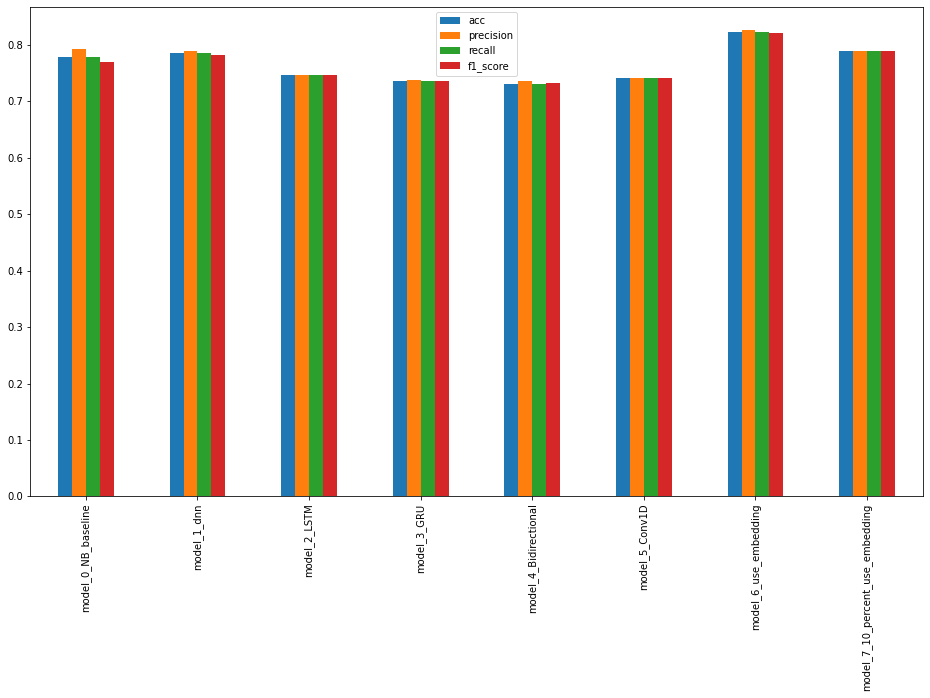

In [ ]:
result.plot(kind="bar",figsize=(16,9))

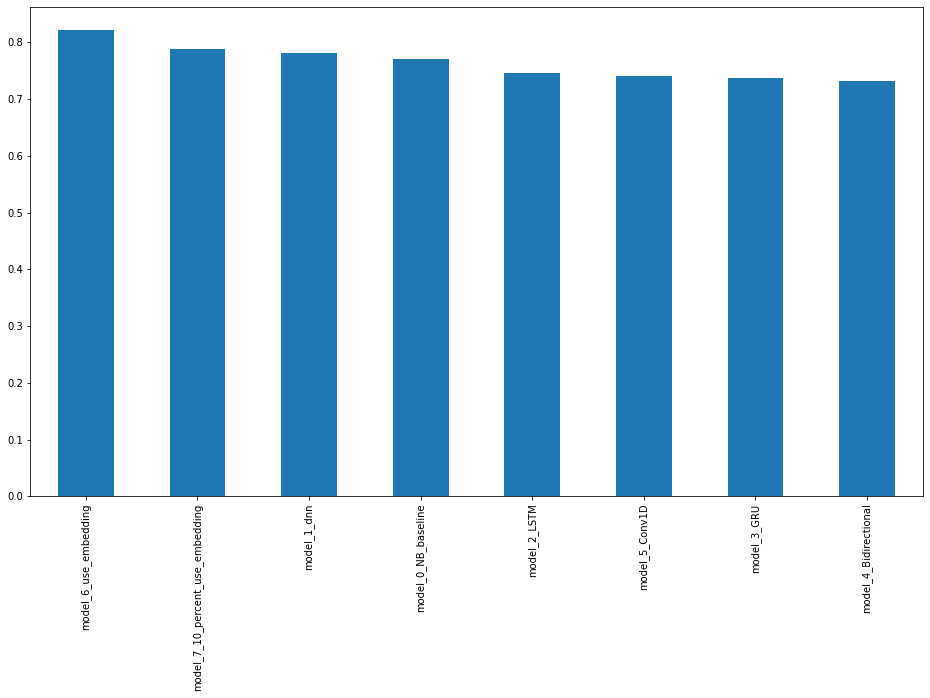

In [ ]:
result.sort_values("f1_score",ascending=False)["f1_score"].plot(kind="bar",figsize=(16,9))

### Tensorboard

In [ ]:
!tensorboard dev upload --logdir "./model_expeirment" --name "SentimentAnalysis" --description "ModelExperiments" --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/yjgbCWc9QPeTnQzoix6X5Q/

[2022-07-07T14:37:51] Started scanning logdir.
[2022-07-07T14:38:01] Total uploaded: 300 scalars, 0 tensors, 10 binary objects (5.4 MB)
[2022-07-07T14:38:01] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/yjgbCWc9QPeTnQzoix6X5Q/


In [ ]:
!tensorboard dev delete --experiment_id "SentimentAnalysis"

Internal error deleting experiment SentimentAnalysis: <_InactiveRpcError of RPC that terminated with:
	status = StatusCode.INVALID_ARGUMENT
	details = "Invalid experiment ID: 'SentimentAnalysis'"
	debug_error_string = "{"created":"@1657205012.203678069","description":"Error received from peer ipv4:34.95.66.171:443","file":"src/core/lib/surface/call.cc","file_line":952,"grpc_message":"Invalid experiment ID: 'SentimentAnalysis'","grpc_status":3}"
>.



### Save Model and Load model
- Save model that have the best performance

In [ ]:
# if the model file formant is h5, we need to specify the custom objects when loading the objec
model_6.save("model_6.h5")

In [ ]:
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={
                                                "KerasLayer":hub.KerasLayer
                                            })

In [ ]:
model_6.evaluate(X_validation,y_validation)

24/24 [==============================] - 2s 17ms/step - loss: 0.3983 - accuracy: 0.8228


[0.3982897102832794, 0.8228346705436707]

In [ ]:
loaded_model_6.evaluate(X_validation,y_validation)

24/24 [==============================] - 1s 19ms/step - loss: 0.3983 - accuracy: 0.8228


[0.3982897102832794, 0.8228346705436707]

In [ ]:
# download the model
from google.colab import files
files.download('model_6.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2022.07.08 - NLP Part 5

### Download Pre-trained model and find the wrongest sample

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

--2022-07-08 13:34:06--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 142.250.188.208, 142.251.33.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   171MB/s    in 5.8s    

2022-07-08 13:34:12 (159 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [ ]:
hf.unzip_data("08_model_6_USE_feature_extractor.zip")

In [ ]:
downloaded_model = tf.keras.models.load_model("08_model_6_USE_feature_extractor")

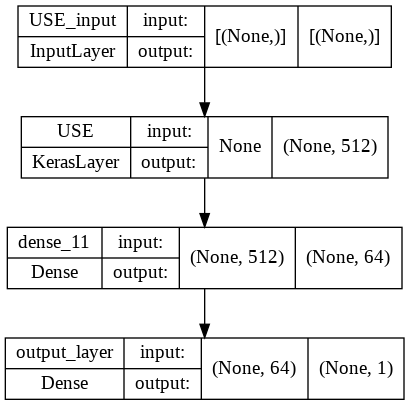

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(downloaded_model,show_shapes=True)

In [ ]:
downloaded_model.evaluate(X_validation,y_validation)

24/24 [==============================] - 6s 11ms/step - loss: 0.3657 - accuracy: 0.8451


[0.36571064591407776, 0.8451443314552307]

In [ ]:
y_pred_prob = downloaded_model.predict(X_validation)
y_pred = tf.squeeze(np.round(downloaded_model.predict(X_validation)))
y_pred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)>

In [ ]:
result_df = pd.DataFrame({
    "text":X_validation,
    "target":y_validation,
    "pred":y_pred,
    "pred_prob":y_pred_prob.flatten()
})

In [ ]:
wrong_pred_df = result_df["target"]!=result_df["pred"]

# only observe the FP case
the_most_wrong = result_df[wrong_pred_df].sort_values("pred_prob",ascending=False)

#if take FN and FP case together. the change to following datafram
#the_most_wrong["abs"] = tf.abs(the_most_wrong["pred"]-the_most_wrong["pred_prob"])
#the_most_wrong.sort_values("abs",ascending=True)

In [ ]:
the_most_wrong.head()

,text,target,pred,pred_prob
656,Russian customs destroyed a total of 319 tons ...,0,1.0,0.924983
428,HereÛªs how media in Pakistan covered the cap...,0,1.0,0.922768
158,Over half of poll respondents worry nuclear di...,0,1.0,0.901509
608,USW: 'The damage from abandoning the deal coul...,0,1.0,0.888064
384,@FoxNewsInsider All Obama is doing is giving a...,0,1.0,0.864093


@SaintRobinho86 someone has to be at the bottom of every league. Tonight clearly demonstrated why the Lions are where they are - sunk!
Target 1, Pred: 0.0, Pred_Prob:0.10678563266992569
--------------------
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife
Target 1, Pred: 0.0, Pred_Prob:0.10425049811601639
--------------------
burned 129 calories doing 24 minutes of Walking 3.5 mph brisk pace #myfitnesspal
Target 1, Pred: 0.0, Pred_Prob:0.10255709290504456
--------------------
TodayÛªs storm will pass; let tomorrowÛªs light greet you with a kiss. Bask in this loving warmth; let your soul return to bliss.
Target 1, Pred: 0.0, Pred_Prob:0.09849575906991959
--------------------
Me watching Law &amp; Order (IB: @sauldale305) (Vine by @NaturalExample) https://t.co/tl29LnU44O
Target 1, Pred: 0.0, Pred_Prob:0.09689097106456757
--------------------
Reddit's new content policy goes into effect many horrible subreddits banned or quarantined ht

### Visualize the model's worst prediction

In [ ]:
# can check FP or FN case
for row in the_most_wrong.iloc[-10:,:].itertuples():
  _,text,target,pred,pred_prob = row
  print(text)
  print(f"Target {target}, Pred: {pred}, Pred_Prob:{pred_prob}")
  print("-"*20)

@SaintRobinho86 someone has to be at the bottom of every league. Tonight clearly demonstrated why the Lions are where they are - sunk!
Target 1, Pred: 0.0, Pred_Prob:0.10678563266992569
--------------------
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife
Target 1, Pred: 0.0, Pred_Prob:0.10425049811601639
--------------------
burned 129 calories doing 24 minutes of Walking 3.5 mph brisk pace #myfitnesspal
Target 1, Pred: 0.0, Pred_Prob:0.10255709290504456
--------------------
TodayÛªs storm will pass; let tomorrowÛªs light greet you with a kiss. Bask in this loving warmth; let your soul return to bliss.
Target 1, Pred: 0.0, Pred_Prob:0.09849575906991959
--------------------
Me watching Law &amp; Order (IB: @sauldale305) (Vine by @NaturalExample) https://t.co/tl29LnU44O
Target 1, Pred: 0.0, Pred_Prob:0.09689097106456757
--------------------
Reddit's new content policy goes into effect many horrible subreddits banned or quarantined ht

### predictionn on the Test Dataset

In [ ]:
test_pred_prob = downloaded_model.predict(test_data_df["text"])
test_pred = tf.squeeze(np.round(test_pred_prob))
test_acutual_label = submission_data_df["target"].to_numpy()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_acutual_label,test_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.63      0.77      3263
         1.0       0.00      0.00      0.00         0

    accuracy                           0.63      3263
   macro avg       0.50      0.31      0.39      3263
weighted avg       1.00      0.63      0.77      3263



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for row in final_data_df.sample(10,random_state=42).itertuples():
  _,text,target = row
  y_pred_prob = downloaded_model.predict([text])
  y_pred = tf.squeeze(np.round(y_pred_prob))
  print(f"{text}")
  print(f"actual:{target},pred:{y_pred}, pred_prob: {tf.squeeze(y_pred_prob)}")
  print("-"*20)
  

Refugees as citizens - The Hindu http://t.co/GJSaAf3U6K
actual:0,pred:1.0, pred_prob: 0.6952428221702576
--------------------
@5SOStag honestly he could say an apocalypse is coming and i would be exited hes so enthusiastic about everything
actual:0,pred:0.0, pred_prob: 0.09767340868711472
--------------------
If you bored as shit don't nobody fuck wit you... But when you busy yo shit get blown up! Smh
actual:0,pred:0.0, pred_prob: 0.07295254617929459
--------------------
@RealTwanBrown Yesterday I Had A Heat Attack ???? And What's Funny Our Relationship ??? Or Our Snapchat
actual:0,pred:0.0, pred_prob: 0.0980691909790039
--------------------
The Devil Wears Prada is still one of my favourite films ??
actual:0,pred:0.0, pred_prob: 0.025186052545905113
--------------------
my father fucking died when the north tower collapsed ON HIM as he was trying to evacuate more people from the building.
actual:0,pred:1.0, pred_prob: 0.9472383260726929
--------------------
Oh itÛªs a soccer ball? I 

### Speed/Score tradeoff

In [ ]:
def pred_timer(model,samples):
  import time
  start_time = time.perf_counter()
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time-start_time
  return total_time,total_time/len(samples),len(samples)

In [ ]:
_,downloaded_model_time_per_pred,_ = pred_timer(downloaded_model,X_validation)
_,baseline_model_time_per_pred,_ = pred_timer(pipeline,X_validation)

In [ ]:
downloaded_model_result = calculate_result(y_validation,
                                           tf.squeeze(np.round(downloaded_model.predict(X_validation))))
baseline_model_result = calculate_result(y_validation,
                                           tf.squeeze(np.round(pipeline.predict(X_validation))))

In [ ]:
import matplotlib.pyplot as plt

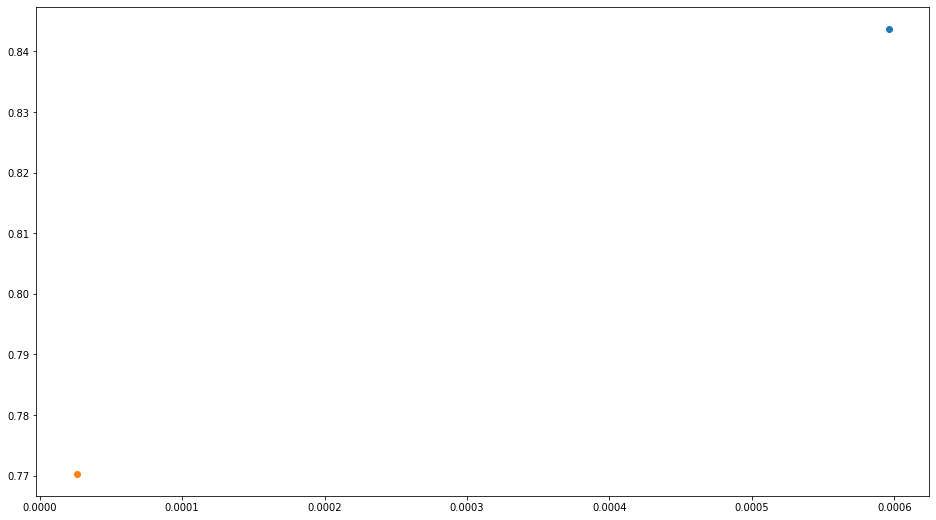

In [ ]:
plt.figure(figsize=(16,9))
plt.scatter(downloaded_model_time_per_pred,downloaded_model_result["f1_score"],label="downloaded_model")
plt.scatter(baseline_model_time_per_pred,baseline_model_result["f1_score"],label="baseline_model")
# the most ideal point is high speed and high performance, the left top corner

### Exxercise

In [ ]:
# Predict the testing dataset and submit a submission.csv to kaggle
final_data_df = pd.concat([test_data_df[["id","text"]],submission_data_df["target"]],axis=1)
final_data_pred = tf.squeeze(np.round(downloaded_model.predict(final_data_df["text"]))).numpy()
final_data_df["pred"] = final_data_pred.astype(int)
final_data_df.drop(["target","text"],axis=1).rename({"pred":"target"},axis=1).to_csv("./submission.csv",index=False)
from google.colab import files
files.download('./submission.csv') 

In [ ]:
# individual model prediction against all aggregated model prediction
from sklearn.ensemble import VotingClassifier
ensemble_model = VotingClassifier(pipeline)
ensemble_model.fit(X_train,y_train)

TypeError: ignored

## Review

In [76]:
#!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
hf.unzip_data("nlp_getting_started.zip")
train_data_df = pd.read_csv("train.csv")
test_data_df = pd.read_csv("test.csv")
submission_data_df = pd.read_csv("sample_submission.csv")
test_data_df["target"] = submission_data_df["target"]

In [77]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding

In [78]:
X = train_data_df["text"].to_numpy()
Y = train_data_df["target"].to_numpy()
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=42,test_size=0.2)

In [79]:
# text vectorization
text_vectorizer = TextVectorization(
    max_tokens = 20000,
    output_mode="int",
    output_sequence_length=15
)

In [81]:
# embedding 
text_vectorizer.adapt(X_train)
vol = text_vectorizer.get_vocabulary()
vol_len = len(vol)
embedding = Embedding(
    input_dim = vol_len,
    output_dim = 128,
    input_length = 15
)

In [93]:
### functional api
inputs = tf.keras.layers.Input(shape=[],dtype=tf.string) # becasue the input is ssting
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x) 
x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32,return_sequences=False))(x) 
x = tf.keras.layers.Dense(10,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.Model(inputs,outputs)

In [83]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           2486016   
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,584,961
Trainable params: 2,584,961
Non-tra

In [94]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [95]:
X_train.shape, X_test.shape, y_train.shape,y_test.shape

((6090,), (1523,), (6090,), (1523,))

In [98]:
history_1 = model.fit(
    X_train,
    y_train,
    validation_data = (X_test, y_test),
    epochs = 10,
    verbose=1,
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
)

Epoch 1/10
191/191 [==============================] - 3s 14ms/step - loss: 0.0825 - accuracy: 0.9737 - val_loss: 0.5722 - val_accuracy: 0.7879 - lr: 1.0000e-08
Epoch 2/10
191/191 [==============================] - 3s 13ms/step - loss: 0.0825 - accuracy: 0.9737 - val_loss: 0.5722 - val_accuracy: 0.7879 - lr: 1.0000e-08
Epoch 3/10
191/191 [==============================] - 2s 13ms/step - loss: 0.0825 - accuracy: 0.9737 - val_loss: 0.5722 - val_accuracy: 0.7879 - lr: 1.0000e-08
Epoch 4/10
191/191 [==============================] - 2s 13ms/step - loss: 0.0825 - accuracy: 0.9737 - val_loss: 0.5722 - val_accuracy: 0.7879 - lr: 1.0000e-09
Epoch 5/10
191/191 [==============================] - 2s 13ms/step - loss: 0.0825 - accuracy: 0.9737 - val_loss: 0.5722 - val_accuracy: 0.7879 - lr: 1.0000e-09
Epoch 6/10
191/191 [==============================] - 2s 13ms/step - loss: 0.0825 - accuracy: 0.9737 - val_loss: 0.5722 - val_accuracy: 0.7879 - lr: 1.0000e-10
Epoch 7/10
191/191 [====================

In [100]:
import tensorflow_hub as hub

In [108]:
### Sequential Model API

use_embedding = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable = False,
    input_shape = [],
    dtype=tf.string, # remember to assing the dtype on the value
    name="use_embedding"
)

In [110]:
model_1 = tf.keras.Sequential([
    use_embedding,
    tf.keras.layers.Dense(10,activation="relu"),
    tf.keras.layers.Dense(1,activation="sigmoid")                           
])

model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [111]:
model_1.fit(
    X_train,
    y_train,
    epochs = 20,
    validation_data = (X_test,y_test)
)

Epoch 1/20
191/191 [==============================] - 11s 27ms/step - loss: 0.5841 - accuracy: 0.7281 - val_loss: 0.4876 - val_accuracy: 0.8011
Epoch 2/20
191/191 [==============================] - 5s 24ms/step - loss: 0.4588 - accuracy: 0.8082 - val_loss: 0.4357 - val_accuracy: 0.8148
Epoch 3/20
191/191 [==============================] - 5s 25ms/step - loss: 0.4290 - accuracy: 0.8125 - val_loss: 0.4223 - val_accuracy: 0.8135
Epoch 4/20
191/191 [==============================] - 5s 27ms/step - loss: 0.4165 - accuracy: 0.8190 - val_loss: 0.4161 - val_accuracy: 0.8188
Epoch 5/20
191/191 [==============================] - 5s 24ms/step - loss: 0.4098 - accuracy: 0.8212 - val_loss: 0.4141 - val_accuracy: 0.8175
Epoch 6/20
191/191 [==============================] - 5s 25ms/step - loss: 0.4049 - accuracy: 0.8210 - val_loss: 0.4136 - val_accuracy: 0.8201
Epoch 7/20
191/191 [==============================] - 5s 25ms/step - loss: 0.4015 - accuracy: 0.8264 - val_loss: 0.4124 - val_accuracy: 0.819

In [112]:
model_1.evaluate(test_data_df["text"],test_data_df["target"])

102/102 [==============================] - 3s 19ms/step - loss: 0.9712 - accuracy: 0.6224


[0.9711644649505615, 0.6224333643913269]